In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd "/gdrive/My Drive/Capstone2020/classification"

/gdrive/My Drive/Capstone2020/classification


In [ ]:
! ls

'모델 기록'    garbage_cls    split.ipynb
 checkpoints   result_image   train.ipynb


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean


    def __call__(self, tensor):
        noise = tensor + torch.randn(tensor.size()) * self.std + self.mean
        return noise

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# 출처 https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from garbage_cls import dataset
from garbage_cls import data
from garbage_cls import GarbageCls
from torch import nn
from torchvision import models
import torchvision.transforms
from torchvision.transforms import CenterCrop, RandomHorizontalFlip, ToTensor, Normalize, RandomApply, RandomPerspective,RandomVerticalFlip,Resize


DATA_ROOT_DIR= '/gdrive/My Drive/Capstone2020/Dataset'

app = GarbageCls(DATA_ROOT_DIR, 'checkpoints')

hyper_params = {
    'num_epochs': 100,
    'lr': 0.001,
    'lr_gamma': 0.5,
    'lr_milestones': [80],
    'log_interval': 10,
    'checkpoint_interval': 1000
}
# batch size =128
    
app.set_hyper_params(**hyper_params)

model = models.densenet121(pretrained=True)

in_features = model.classifier.in_features
# 전체 freeze
for param in model.parameters():
    param.requires_grad_(False)
    pass

for param in model.features[-2].parameters():
  param.requires_grad_(True)
  pass

model.classifier = nn.Linear(in_features, app.num_classes)

model = model.cuda()
               
app.set_model(model)

app.set_data_transform('train', transforms.Compose(
                          [
                           Resize((300,300)),
                           RandomHorizontalFlip(),
                           RandomVerticalFlip(),
                           ToTensor(),
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                           RandomApply([AddGaussianNoise(0., 0.1)], p=0.2)
                           ])
                      )
app.set_data_transform('val', transforms.Compose(
                        [
                         Resize((300,300)),
                         ToTensor(),
                         Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])
                      )

app.run()

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


initializing dataloaders..!
logging every 10, saving every 1000
using CUDA
test start
[['KakaoTalk_20200522_202747523_25.jpg', 'Can'], ['botol_kaca_korken_ikea_1448961827_123179b2.jpg', 'Glass'], ['IMG_5019.JPG', 'Vinyl'], ['KakaoTalk_20200531_232712453_04.jpg', 'Glass'], ['2935_4183535_1.jpg', 'Paper'], ['IMG_5928.JPG', 'Paper'], ['KakaoTalk_20200531_234124636_13.jpg', 'Paper'], ['KakaoTalk_20200530_151614135.jpg', 'Paper'], ['IMG_5975.JPG', 'PET'], ['사본 -IMG_5345.jpg', 'Plastic'], ['IMG_5657.JPG', 'Can'], ['IMG_5261.JPG', 'Plastic'], ['IMG_5963.JPG', 'PET'], ['유리10_1.jpg', 'Glass'], ['유리 (12).jpg', 'Glass'], ['사본 -사본 -20181008_153902.jpg', 'PET'], ['IMG_5860.JPG', 'Vinyl'], ['IMG_5126.JPG', 'Vinyl'], ['IMG_5699.JPG', 'PET'], ['KakaoTalk_20200518_160642103_11.jpg', 'Plastic'], ['다운로드 (6).jpg', 'PET'], ['39afdf6dcbc5e.jpg', 'Can'], ['Tusker_Beer.jpg', 'Glass'], ['캔3.jpg', 'Can'], ['플라스틱2.png', 'Plastic'], ['IMG_5214.JPG', 'Paper'], ['images (19).jpg', 'Paper']

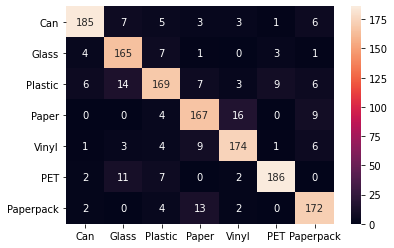

1218 1400
Accuracy: 87 %


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from garbage_cls import dataset
from garbage_cls import data
from garbage_cls import GarbageCls
from torch import nn
from torchvision import models
import torchvision.transforms
from torchvision.transforms import CenterCrop, RandomHorizontalFlip, ToTensor, Normalize, RandomApply, RandomPerspective,RandomVerticalFlip,ColorJitter,Resize

TEST_ROOT_DIR='/gdrive/My Drive/Capstone2020/Dataset'

app = GarbageCls(TEST_ROOT_DIR, 'checkpoints')

# DenseNet initializae
model = models.densenet121(pretrained=True)
in_features = model.classifier.in_features
for param in model.parameters():
    param.requires_grad_(False)
    pass

model.classifier = nn.Linear(in_features, app.num_classes)

model = model.cuda()
app.set_model(model)

app.set_data_transform('test', transforms.Compose([
                         Resize((300,300)),
                         ToTensor(),
                         Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                      )

app.test()

In [ ]:
# model.cpu()
# model.eval()
# example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.trace(model, example)
# traced_script_module.save("/gdrive/My Drive/model.pt")